#  Riiid! Answer Correctness Prediction

**Background**: According to Riiid Labs, AI systems are being used in online learning by launching an AI tutor based on deep-learning algorithms.

**Problem**: Students are not able to choose learning experiences based on their personal background, skills and interest.

**Source Data**: AI education data from Riiid Ednet open database

**Goal**: To create algorithms for "Knowledge Tracing" for student answer prediction in order to develop a custom learning profile and customize the training materials for each student
based on their ability, preferred mode of learning, and experience. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import gc
import datatable as dt
sns.set()
np.set_printoptions(suppress=True)
pd.set_option('float_format', '{:f}'.format)

In [49]:
import datatable as dt

In [50]:
%time data = pd.read_csv('train.csv')

#%time data = pd.read_csv('train.csv',nrows=1000000)
# data = pd.read_csv('train.csv',
#                 usecols=[1, 2, 3,4,7,8,9], dtype={'timestamp': 'int64', 
#                                                   'user_id': 'int32' ,
#                                                   'content_id': 'int16',
#                                                   'content_type_id': 'int8',
#                                                   'answered_correctly':'int8',
#                                                   'prior_question_elapsed_time': 
#                                                   'float32','prior_question_had_explanation':
#                                                   'boolean'}
#               )

CPU times: user 49.4 s, sys: 26 s, total: 1min 15s
Wall time: 1min 25s


In [51]:
data.dtypes #train data set

row_id                              int64
timestamp                           int64
user_id                             int64
content_id                          int64
content_type_id                     int64
task_container_id                   int64
user_answer                         int64
answered_correctly                  int64
prior_question_elapsed_time       float64
prior_question_had_explanation     object
dtype: object

In [52]:
def downcast_df_int_columns(df):
    list_of_columns = list(df.select_dtypes(include=["int32", "int64"]).columns)
        
    if len(list_of_columns)>=1:
        max_string_length = max([len(col) for col in list_of_columns]) # finds max string length for better status printing
        print("downcasting integers for:", list_of_columns, "\n")
        
        for col in list_of_columns:
            print("reduced memory usage for:  ", col.ljust(max_string_length+2)[:max_string_length+2],
                  "from", str(round(df[col].memory_usage(deep=True)*1e-6,2)).rjust(8), "to", end=" ")
            df[col] = pd.to_numeric(df[col], downcast="integer")
            print(str(round(df[col].memory_usage(deep=True)*1e-6,2)).rjust(8))
    else:
        print("no columns to downcast")
    
    gc.collect()
    
    print("done")

In [53]:
downcast_df_int_columns(data)

downcasting integers for: ['row_id', 'timestamp', 'user_id', 'content_id', 'content_type_id', 'task_container_id', 'user_answer', 'answered_correctly'] 

reduced memory usage for:   row_id               from   809.84 to   404.92
reduced memory usage for:   timestamp            from   809.84 to   809.84
reduced memory usage for:   user_id              from   809.84 to   404.92
reduced memory usage for:   content_id           from   809.84 to   202.46
reduced memory usage for:   content_type_id      from   809.84 to   101.23
reduced memory usage for:   task_container_id    from   809.84 to   202.46
reduced memory usage for:   user_answer          from   809.84 to   101.23
reduced memory usage for:   answered_correctly   from   809.84 to   101.23
done


In [54]:
df = data[:]

In [55]:
df.set_index("row_id", inplace=True)

In [56]:
lectures = pd.read_csv('lectures.csv')
questions = pd.read_csv('questions.csv')

In [57]:
downcast_df_int_columns(lectures)

downcasting integers for: ['lecture_id', 'tag', 'part'] 

reduced memory usage for:   lecture_id   from      0.0 to      0.0
reduced memory usage for:   tag          from      0.0 to      0.0
reduced memory usage for:   part         from      0.0 to      0.0
done


In [58]:
downcast_df_int_columns(questions)

downcasting integers for: ['question_id', 'bundle_id', 'correct_answer', 'part'] 

reduced memory usage for:   question_id      from     0.11 to     0.03
reduced memory usage for:   bundle_id        from     0.11 to     0.03
reduced memory usage for:   correct_answer   from     0.11 to     0.01
reduced memory usage for:   part             from     0.11 to     0.01
done


In [59]:
lectures.dtypes

lecture_id     int16
tag            int16
part            int8
type_of       object
dtype: object

In [60]:
questions.dtypes

question_id        int16
bundle_id          int16
correct_answer      int8
part                int8
tags              object
dtype: object

In [61]:
df.dtypes

timestamp                           int64
user_id                             int32
content_id                          int16
content_type_id                      int8
task_container_id                   int16
user_answer                          int8
answered_correctly                   int8
prior_question_elapsed_time       float64
prior_question_had_explanation     object
dtype: object

In [62]:
df.sample()

,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
row_id,,,,,,,,,
68587317,3647342390,1459012183,4982,0,1251,2,1,22000.000000,True


In [63]:
df.shape

(101230332, 9)

In [64]:
df.describe()

,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time
count,101230332.000000,101230332.000000,101230332.000000,101230332.000000,101230332.000000,101230332.000000,101230332.000000,98878794.000000
mean,7703643654.326523,1076732424.202999,5219.604757,0.019352,904.062366,1.376123,0.625164,25423.810043
std,11592655308.525589,619716349.500642,3866.358940,0.137760,1358.302181,1.192896,0.522531,19948.146709
min,0.000000,115.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,0.000000
25%,524343559.000000,540811564.000000,2063.000000,0.000000,104.000000,0.000000,0.000000,16000.000000
50%,2674233764.500000,1071781070.000000,5026.000000,0.000000,382.000000,1.000000,1.000000,21000.000000
75%,9924550562.750000,1615741676.000000,7425.000000,0.000000,1094.000000,3.000000,1.000000,29666.000000
max,87425772049.000000,2147482888.000000,32736.000000,1.000000,9999.000000,3.000000,1.000000,300000.000000


In [65]:
questions

,question_id,bundle_id,correct_answer,part,tags
0,0,0,0,1,51 131 162 38
1,1,1,1,1,131 36 81
2,2,2,0,1,131 101 162 92
3,3,3,0,1,131 149 162 29
4,4,4,3,1,131 5 162 38
...,...,...,...,...,...
13518,13518,13518,3,5,14
13519,13519,13519,3,5,8
13520,13520,13520,2,5,73
13521,13521,13521,0,5,125


In [66]:
lectures.shape

(418, 4)

In [67]:
questions

,question_id,bundle_id,correct_answer,part,tags
0,0,0,0,1,51 131 162 38
1,1,1,1,1,131 36 81
2,2,2,0,1,131 101 162 92
3,3,3,0,1,131 149 162 29
4,4,4,3,1,131 5 162 38
...,...,...,...,...,...
13518,13518,13518,3,5,14
13519,13519,13519,3,5,8
13520,13520,13520,2,5,73
13521,13521,13521,0,5,125


In [68]:
lectures

,lecture_id,tag,part,type_of
0,89,159,5,concept
1,100,70,1,concept
2,185,45,6,concept
3,192,79,5,solving question
4,317,156,5,solving question
...,...,...,...,...
413,32535,8,5,solving question
414,32570,113,3,solving question
415,32604,24,6,concept
416,32625,142,2,concept


In [69]:
df.shape

(101230332, 9)

In [70]:
len(df) - df.count()

timestamp                               0
user_id                                 0
content_id                              0
content_type_id                         0
task_container_id                       0
user_answer                             0
answered_correctly                      0
prior_question_elapsed_time       2351538
prior_question_had_explanation     392506
dtype: int64

In [71]:
df.content_type_id.unique()

array([0, 1], dtype=int8)

## Exploratory Data Analysis (EDA)

### Unique value for each categorical feature

/Users/yatipachaleenutthawut/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


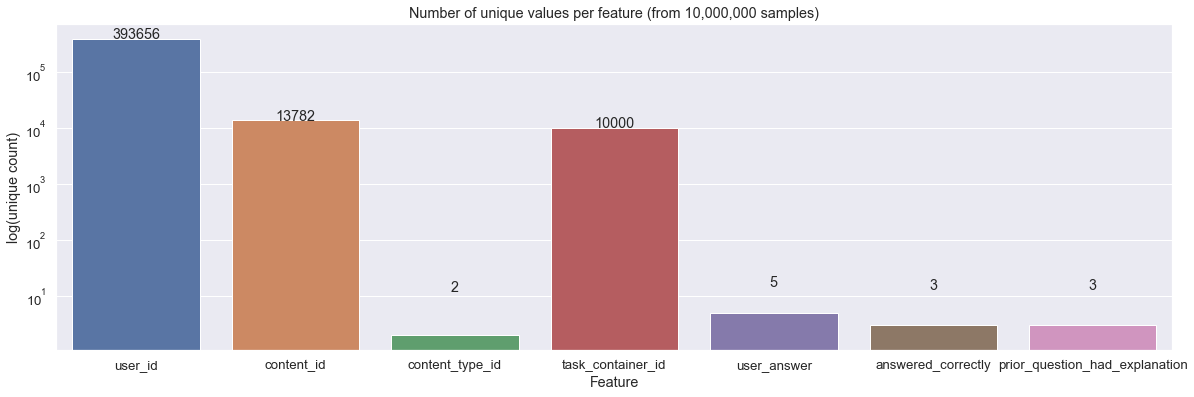

In [73]:
plt.figure(figsize=(20, 6))
cols = ['user_id', 'content_id', 'content_type_id', 'task_container_id',
        'user_answer','answered_correctly','prior_question_had_explanation']
uniques = [len(df[col].unique()) for col in cols]
sns.set(font_scale=1.2)
ax = sns.barplot(cols, uniques, log=True)
ax.set(xlabel='Feature', ylabel='log(unique count)',
       title='Number of unique values per feature (from 10,000,000 samples)')
for p, uniq in zip(ax.patches, uniques):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 10,
            uniq,
            ha="center") 

### Content type id per user’s answer

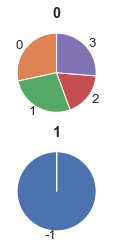

In [74]:
fig, ax = plt.subplots(2) 
ax = ax.flatten()
tab = pd.crosstab(df['content_type_id'],df['user_answer'])
for i,cat in enumerate(tab.index):
    tab.loc[cat].plot.pie(ax=ax[i],startangle=90)
    ax[i].set_ylabel('')
    ax[i].set_title(cat, fontweight='bold')

### Content type id per answer correctness

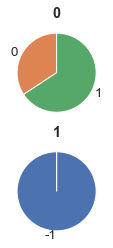

In [75]:
fig, ax = plt.subplots(2)
ax = ax.flatten()
tab = pd.crosstab(df['content_type_id'],df['answered_correctly'])
for i,cat in enumerate(tab.index):
    tab.loc[cat].plot.pie(ax=ax[i],startangle=90)
    ax[i].set_ylabel('')
    ax[i].set_title(cat, fontweight='bold')

### The number of correct answers

<AxesSubplot:xlabel='answered_correctly', ylabel='count'>

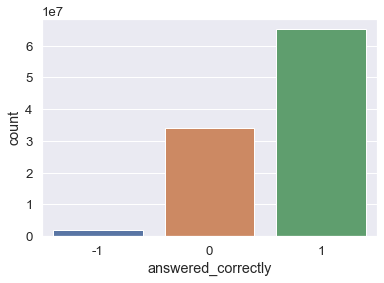

In [76]:
sns.countplot(data = df, x = 'answered_correctly')

In [77]:
df.dtypes

timestamp                           int64
user_id                             int32
content_id                          int16
content_type_id                      int8
task_container_id                   int16
user_answer                          int8
answered_correctly                   int8
prior_question_elapsed_time       float64
prior_question_had_explanation     object
dtype: object

### Correct and incorrect user answers

/Users/yatipachaleenutthawut/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/yatipachaleenutthawut/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Incorrectl answered user answers')

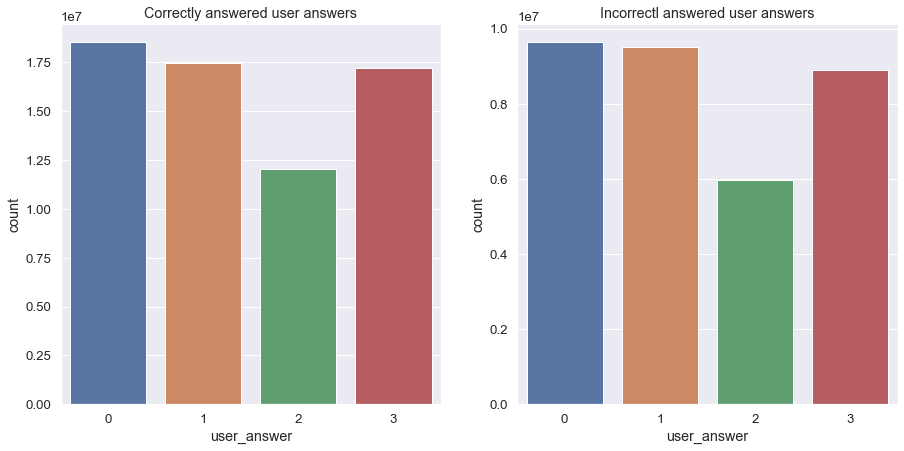

In [78]:
df_correct_user_answers = df[df['answered_correctly']==1]['user_answer']
df_incorrect_user_answers = df[df['answered_correctly']==0]['user_answer']

 
plt.figure(figsize=(15,7))
plt.subplot(121)
sns.countplot(df_correct_user_answers)
plt.title("Correctly answered user answers")
plt.subplot(122)
sns.countplot(df_incorrect_user_answers)
plt.title("Incorrectl answered user answers")


### The proportion of correct and incorrect answers in each content id

In [79]:
df_question = df[df['answered_correctly']!=-1]
correct_per = pd.crosstab(df_question['content_id'],
            df_question['answered_correctly']).apply(lambda r: r/r.sum(), axis=1)

In [80]:
correct_per.reset_index().sort_values(by=1).head(10)

answered_correctly,content_id,0,1
1485,1485,1.000000,0.000000
10007,10007,1.000000,0.000000
1484,1484,1.000000,0.000000
1486,1486,1.000000,0.000000
10062,10062,0.908248,0.091752
7639,7639,0.899393,0.100607
3125,3125,0.864035,0.135965
9220,9220,0.855247,0.144753
7487,7487,0.852320,0.147680
10924,10924,0.851225,0.148775


In [81]:
df.dtypes

timestamp                           int64
user_id                             int32
content_id                          int16
content_type_id                      int8
task_container_id                   int16
user_answer                          int8
answered_correctly                   int8
prior_question_elapsed_time       float64
prior_question_had_explanation     object
dtype: object

### The correlation between the number of questions and accuracy

/Users/yatipachaleenutthawut/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


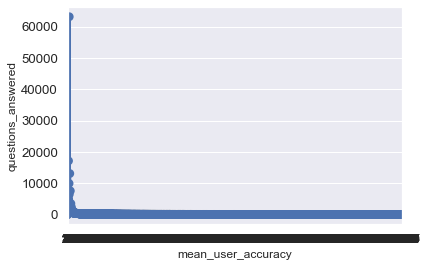

In [82]:
user_answers_ = df.groupby('user_id').agg({ 'answered_correctly':['mean', 'count']}).copy()
user_answers_.columns = ['mean_user_accuracy', 'questions_answered']

grouped_df = user_answers_.groupby(["questions_answered"])["mean_user_accuracy"].aggregate("count").reset_index()

sns.pointplot(grouped_df['questions_answered'].values,grouped_df['mean_user_accuracy'].values, alpha=0.8)
plt.ylabel('questions_answered', fontsize=12)
plt.xlabel('mean_user_accuracy', fontsize=12)
#plt.xticks(rotation='vertical')
plt.show()
# the number of question increase -> accuracy decrease

-----------

## Question

In [83]:
df_qt = df[df['content_type_id']==0] #question


In [84]:
df_qt = df_qt.merge(questions, how='left',  left_on='content_id', right_on='question_id')


In [85]:

df_qt.drop('question_id',axis=1,inplace = True)

In [86]:
df_qt.sample()

,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,bundle_id,correct_answer,part,tags
79334726,2910735307,1721891790,1785,0,410,0,1,3666.000000,True,1784,0,3,74 38 81


In [87]:
df_qt_correct = df_qt[df_qt['answered_correctly']==1]

df_qt_correct.sample()


,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,bundle_id,correct_answer,part,tags
84161569,419860575,1827711444,6860,0,73,1,1,38500.000000,True,6857,1,6,65 162


In [88]:
df_qt_incorrect = df_qt[df_qt['answered_correctly']==0]

df_qt_incorrect.sample()

,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,bundle_id,correct_answer,part,tags
21560322,521320769,472351743,7893,0,488,3,0,19000.000000,True,7893,1,1,131 104 38


### Unique value for each question parts

/Users/yatipachaleenutthawut/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/yatipachaleenutthawut/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/yatipachaleenutthawut/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will resul

Text(0.5, 1.0, 'Parts incorrect count')

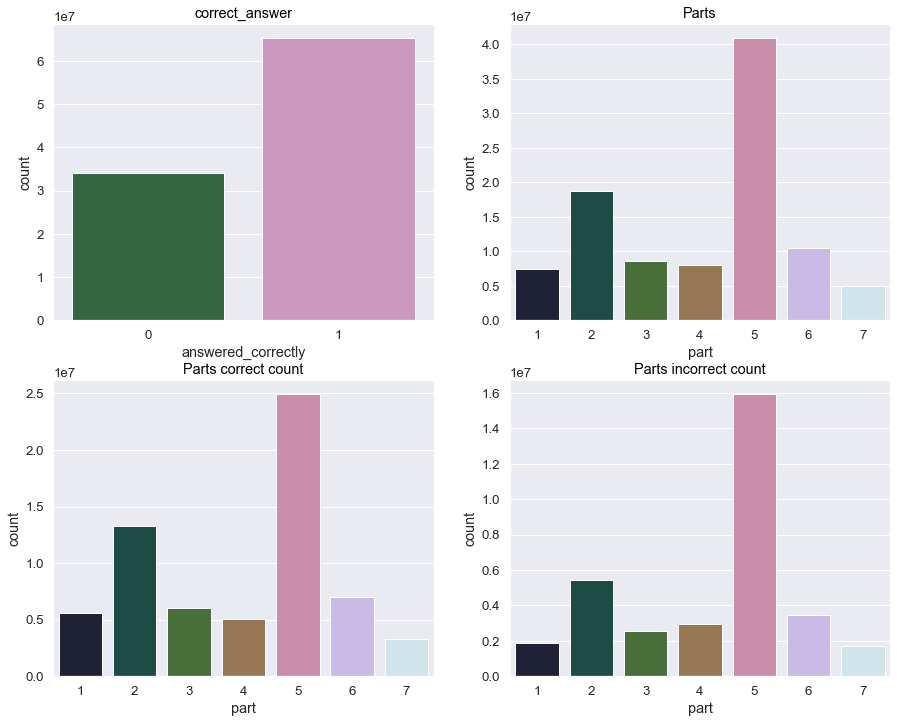

In [89]:
plt.figure(figsize=(15,12))

sns.set_style('darkgrid')
plt.subplot(221)
sns.countplot(df_qt['answered_correctly'], palette='cubehelix')
plt.title('correct_answer',color='black')

sns.set_style('darkgrid')
plt.subplot(222)
sns.countplot(df_qt['part'], palette='cubehelix')
plt.title('Parts',color='black')


sns.set_style('darkgrid')
plt.subplot(223)
sns.countplot(df_qt_correct['part'], palette='cubehelix')
plt.title('Parts correct count',color='black')

sns.set_style('darkgrid')
plt.subplot(224)
sns.countplot(df_qt_incorrect['part'], palette='cubehelix')
plt.title('Parts incorrect count',color='black')



### Replace NaN value by overwriting False in existing dataframe

In [90]:
len(df_qt) - df_qt.count()

timestamp                              0
user_id                                0
content_id                             0
content_type_id                        0
task_container_id                      0
user_answer                            0
answered_correctly                     0
prior_question_elapsed_time       392506
prior_question_had_explanation    392506
bundle_id                              0
correct_answer                         0
part                                   0
tags                                   1
dtype: int64

In [91]:
df_qt.fillna(False,inplace = True)


In [92]:
len(df_qt) - df_qt.count()

timestamp                         0
user_id                           0
content_id                        0
content_type_id                   0
task_container_id                 0
user_answer                       0
answered_correctly                0
prior_question_elapsed_time       0
prior_question_had_explanation    0
bundle_id                         0
correct_answer                    0
part                              0
tags                              0
dtype: int64

### Counting individual user over difference content id

In [93]:
user_content = df_qt.groupby('user_id')['content_id'].value_counts().reset_index(name='Count')
user_content.head(10)

,user_id,content_id,Count
0,115,4,1
1,115,6,1
2,115,25,1
3,115,45,1
4,115,50,1
5,115,51,1
6,115,55,1
7,115,57,1
8,115,100,1
9,115,104,1


In [94]:
df_train =pd.merge(df_qt,user_content,how='left',on=['user_id','content_id'])
df_train.head()

,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,bundle_id,correct_answer,part,tags,Count
0,0,115,5692,0,1,3,1,False,False,5692,3,5,151,1
1,56943,115,5716,0,2,2,1,37000.000000,False,5716,2,5,168,1
2,118363,115,128,0,0,0,1,55000.000000,False,128,0,1,131 149 92,1
3,131167,115,7860,0,3,0,1,19000.000000,False,7860,0,1,131 104 81,1
4,137965,115,7922,0,4,1,1,11000.000000,False,7922,1,1,131 149 92,1


### User who answered each content id at first time

In [95]:
df_train['is_first_time'] = df_train['Count'].apply(lambda x: True if x == 1 else 0)
df_train.head()

,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,bundle_id,correct_answer,part,tags,Count,is_first_time
0,0,115,5692,0,1,3,1,False,False,5692,3,5,151,1,True
1,56943,115,5716,0,2,2,1,37000.000000,False,5716,2,5,168,1,True
2,118363,115,128,0,0,0,1,55000.000000,False,128,0,1,131 149 92,1,True
3,131167,115,7860,0,3,0,1,19000.000000,False,7860,0,1,131 104 81,1,True
4,137965,115,7922,0,4,1,1,11000.000000,False,7922,1,1,131 149 92,1,True


In [96]:

first_content = pd.crosstab(df_train['Count'],
            df_train['answered_correctly']).apply(lambda r: r/r.sum(), axis=1)

In [97]:
first_content.columns = ['answered_incorrect', 'answered_correct']
first_content

,answered_incorrect,answered_correct
Count,,
1,0.316076,0.683924
2,0.443337,0.556663
3,0.433347,0.566653
4,0.413732,0.586268
5,0.410233,0.589767
6,0.400465,0.599535
7,0.392409,0.607591
8,0.376174,0.623826
9,0.364007,0.635993


In [98]:
first_content=first_content.reset_index()

In [99]:
first_content.sample()

,Count,answered_incorrect,answered_correct
56,82,0.024390,0.975610


### The trend of counting number of times that user answer each content id
 

/Users/yatipachaleenutthawut/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


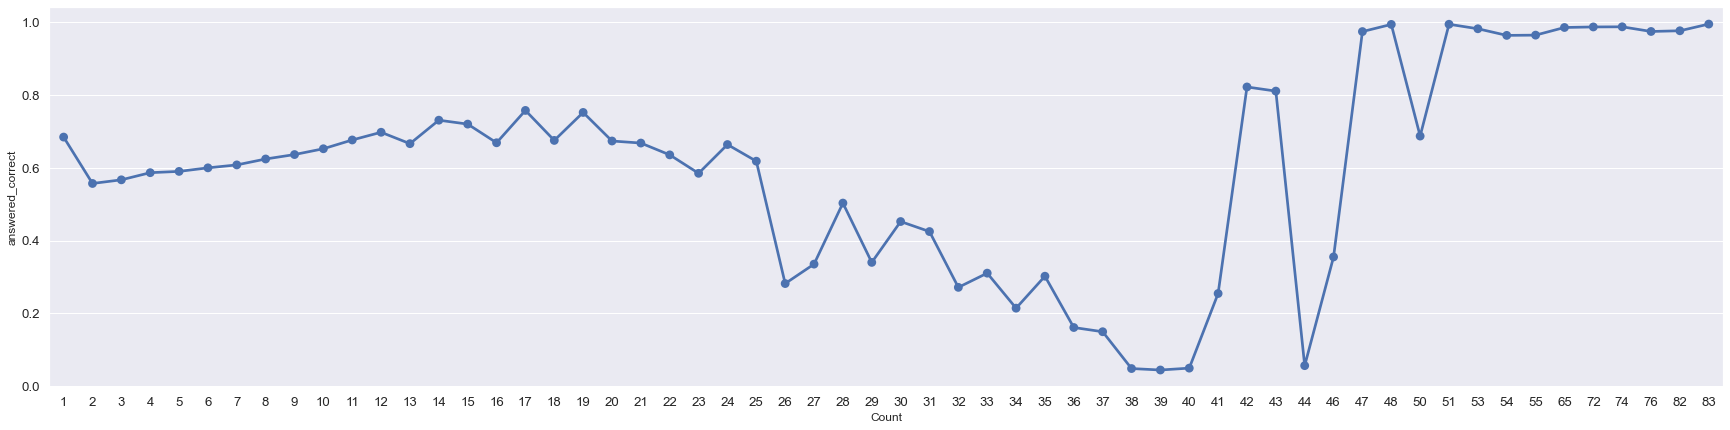

In [100]:
plt.figure(figsize=(30,7))
sns.pointplot(first_content['Count'].values, first_content['answered_correct'].values,
              alpha=0.8)
plt.ylabel('answered_correct', fontsize=12)
plt.xlabel('Count', fontsize=12)
#plt.xticks(rotation='vertical')
plt.show()

In [101]:
df_train.sample()

,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,bundle_id,correct_answer,part,tags,Count,is_first_time
10653343,2400120368,236474756,9766,0,401,3,1,14000.000000,True,9766,3,5,96,2,0


### Categorical data and dropping uninformative dataset
 

In [102]:
obj=['user_id','content_id','task_container_id','prior_question_had_explanation','bundle_id','correct_answer','part','is_first_time','answered_correctly']
X_cat=['user_id','content_id','task_container_id','prior_question_had_explanation','bundle_id','correct_answer','part','is_first_time','Count']

drop = ['timestamp','content_type_id','user_answer','answered_correctly','prior_question_elapsed_time','tags']

y=['answered_correctly']


In [103]:
for i in obj:
    df_train[i] = df_train[i].astype('category')

df_train.dtypes

timestamp                            int64
user_id                           category
content_id                        category
content_type_id                       int8
task_container_id                 category
user_answer                           int8
answered_correctly                category
prior_question_elapsed_time         object
prior_question_had_explanation    category
bundle_id                         category
correct_answer                    category
part                              category
tags                                object
Count                                int64
is_first_time                     category
dtype: object

## Categorical encoding using One-Hot-Encoder
 

In [104]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse=False)
encoded_features = pd.DataFrame(ohe.fit_transform(df_train[['part']]))
ohe.categories_



part_cols = [f'part_{cat}' for cat in ohe.categories_[0]]








dummy_cols_names = [*part_cols]
encoded_features.columns = dummy_cols_names


In [105]:
df_train = pd.concat([df_train, encoded_features], axis=1)
df_train.head(5)

,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,bundle_id,...,tags,Count,is_first_time,part_1,part_2,part_3,part_4,part_5,part_6,part_7
0,0,115,5692,0,1,3,1,False,False,5692,...,151,1,True,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
1,56943,115,5716,0,2,2,1,37000.000000,False,5716,...,168,1,True,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
2,118363,115,128,0,0,0,1,55000.000000,False,128,...,131 149 92,1,True,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,131167,115,7860,0,3,0,1,19000.000000,False,7860,...,131 104 81,1,True,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,137965,115,7922,0,4,1,1,11000.000000,False,7922,...,131 149 92,1,True,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


## Take 10M samples data and split test/train dataset

In [106]:
df_train = df_train.sample(10000000)

In [107]:
df_train.dtypes

timestamp                            int64
user_id                           category
content_id                        category
content_type_id                       int8
task_container_id                 category
user_answer                           int8
answered_correctly                category
prior_question_elapsed_time         object
prior_question_had_explanation    category
bundle_id                         category
correct_answer                    category
part                              category
tags                                object
Count                                int64
is_first_time                     category
part_1                             float64
part_2                             float64
part_3                             float64
part_4                             float64
part_5                             float64
part_6                             float64
part_7                             float64
dtype: object

In [108]:
del data
del df_qt_incorrect
del df_qt_correct
del user_answers_
del grouped_df
del df_question
del correct_per
del df_correct_user_answers
del df_incorrect_user_answers

In [109]:
from sklearn.model_selection import train_test_split
X_rf=df_train.drop(drop,axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X_rf,df_train[y], test_size=0.2, random_state=42)

print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(8000000, 16) (2000000, 16) (8000000, 1) (2000000, 1)


In [110]:
X_train.dtypes

user_id                           category
content_id                        category
task_container_id                 category
prior_question_had_explanation    category
bundle_id                         category
correct_answer                    category
part                              category
Count                                int64
is_first_time                     category
part_1                             float64
part_2                             float64
part_3                             float64
part_4                             float64
part_5                             float64
part_6                             float64
part_7                             float64
dtype: object

In [111]:
y_train.dtypes

answered_correctly    category
dtype: object

## Feature Selection by SelectKBest (chi)

In [112]:
from sklearn.feature_selection import SelectKBest, chi2
fs = SelectKBest(score_func=chi2, k='all')
# learn relationship from training data
fs.fit(X_train, y_train)
# transform train input data
X_train_fs = fs.transform(X_train)
# transform test input data
X_test_fs = fs.transform(X_test)

In [113]:
for i in range(len(fs.scores_)):
	print('Feature %d: %f' % (i, fs.scores_[i]))


Feature 0: 756866842.250324
Feature 1: 7312297.908830
Feature 2: 57323331.786574
Feature 3: 8240.164236
Feature 4: 7313373.799756
Feature 5: 2096.368418
Feature 6: 30428.718199
Feature 7: 23456.865786
Feature 8: 19738.438920
Feature 9: 20199.785824
Feature 10: 17745.231404
Feature 11: 5897.917226
Feature 12: 2036.370108
Feature 13: 32235.660345
Feature 14: 604.468663
Feature 15: 8.770247


In [114]:
names = X_train.columns.values[fs.get_support()]
scores = fs.scores_[fs.get_support()]
names_scores = list(zip(names, scores))
ns_df = pd.DataFrame(data = names_scores, columns=['Feat_names', 'F_Scores'])
#Sort the dataframe for better visualization
ns_df_sorted = ns_df.sort_values(['F_Scores', 'Feat_names'], ascending = [False, True])
print(ns_df_sorted)

                        Feat_names         F_Scores
0                          user_id 756866842.250324
2                task_container_id  57323331.786574
4                        bundle_id   7313373.799756
1                       content_id   7312297.908830
13                          part_5     32235.660345
6                             part     30428.718199
7                            Count     23456.865786
9                           part_1     20199.785824
8                    is_first_time     19738.438920
10                          part_2     17745.231404
3   prior_question_had_explanation      8240.164236
11                          part_3      5897.917226
5                   correct_answer      2096.368418
12                          part_4      2036.370108
14                          part_6       604.468663
15                          part_7         8.770247


In [115]:
X_train.dtypes

user_id                           category
content_id                        category
task_container_id                 category
prior_question_had_explanation    category
bundle_id                         category
correct_answer                    category
part                              category
Count                                int64
is_first_time                     category
part_1                             float64
part_2                             float64
part_3                             float64
part_4                             float64
part_5                             float64
part_6                             float64
part_7                             float64
dtype: object

## Cross-Validation and RandomForestClassifier

In [116]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import  GroupKFold
from sklearn.model_selection import GridSearchCV
parameters = {
    'n_estimators'      : [10, 20, 50, 100, 200],
    'max_depth'         : [5,6,7,8,9,10,11,12,13,14,15],
    'random_state'      : [42],
}

rf = RandomForestClassifier()


In [117]:
groups = X_train['part']
cv = GroupKFold(n_splits=3)
cv = cv.split(X_train, y_train, groups)

gs_rf = GridSearchCV(rf, parameters, cv=cv,verbose = 50, n_jobs=-1)
gs_rf.fit(X_train, y_train)



Fitting 3 folds for each of 55 candidates, totalling 165 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  9.4min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed: 10.0min
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed: 11.3min
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed: 11.8min
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed: 14.1min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed: 14

[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed: 220.7min
[Parallel(n_jobs=-1)]: Done 131 tasks      | elapsed: 221.5min
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed: 221.8min
[Parallel(n_jobs=-1)]: Done 133 tasks      | elapsed: 223.6min
[Parallel(n_jobs=-1)]: Done 134 tasks      | elapsed: 224.2min
[Parallel(n_jobs=-1)]: Done 135 tasks      | elapsed: 225.2min
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed: 226.4min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed: 227.8min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed: 229.3min
[Parallel(n_jobs=-1)]: Done 139 tasks      | elapsed: 236.6min
[Parallel(n_jobs=-1)]: Done 140 tasks      | elapsed: 240.8min
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed: 240.9min
[Parallel(n_jobs=-1)]: Done 142 tasks      | elapsed: 249.2min
[Parallel(n_jobs=-1)]: Done 143 tasks      | elapsed: 252.5min
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed: 255.3min
[Parallel(n_jobs=-1)]: Done 145 tasks      | elapsed: 2

/Users/yatipachaleenutthawut/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:765: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


GridSearchCV(cv=<generator object _BaseKFold.split at 0x7fbff4507cf0>,
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
                         'n_estimators': [10, 20, 50, 100, 200],
                         'random_state': [42]},
             verbose=50)

In [118]:
gs_rf.best_estimator_

RandomForestClassifier(max_depth=5, n_estimators=20, random_state=42)

In [119]:
from sklearn.metrics import make_scorer, accuracy_score
gs_rf.best_estimator_
best_model_rf = gs_rf.best_estimator_
best_model_rf.fit(X_train,y_train)
y_pred_test_rf =best_model_rf.predict(X_test)
accuracy_score(y_test, y_pred_test_rf)

<ipython-input-119-b10ac6bcd380>:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  best_model_rf.fit(X_train,y_train)


0.6710795

In [120]:
y_probs = [0 for _ in range(len(y_test))]
yl_probs = best_model_rf.predict_proba(X_test)
yl_preds = yl_probs[:, 1]
from sklearn.metrics import roc_curve, roc_auc_score
y_auc = roc_auc_score(y_test, y_probs)
yl_auc = roc_auc_score(y_test, yl_preds)
print('Random (chance) Prediction: AUROC = %.3f' % (y_auc))
print('RandomForestClassifiert: AUROC = %.3f' % (yl_auc))

Random (chance) Prediction: AUROC = 0.500
RandomForestClassifiert: AUROC = 0.626


In [121]:
y_fpr, y_tpr, _ = roc_curve(y_test, y_probs) 
yl_fpr, yl_tpr, _ = roc_curve(y_test, yl_preds)

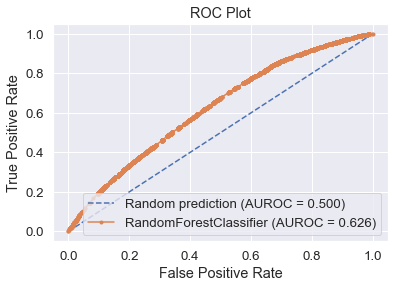

In [122]:
plt.plot(y_fpr, y_tpr, linestyle='--', label='Random prediction (AUROC = %0.3f)' % y_auc)
plt.plot(yl_fpr, yl_tpr, marker='.', label='RandomForestClassifier (AUROC = %0.3f)' % yl_auc)
plt.title('ROC Plot') 
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate') 
plt.legend()  
plt.show()

In [123]:
from sklearn.metrics import make_scorer, accuracy_score
gs_rf.best_estimator_
best_model_rf = gs_rf.best_estimator_
best_model_rf.fit(X_train,y_train)
y_pred_test_rf =best_model_rf.predict(X_test)
accuracy_score(y_test, y_pred_test_rf)

<ipython-input-123-b10ac6bcd380>:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  best_model_rf.fit(X_train,y_train)


0.6710795

In [125]:
coef_table = pd.DataFrame(list(X_train.columns)).copy()
coef_table.insert(len(coef_table.columns),"Coefs",abs(best_model_rf.feature_importances_.transpose()))
coef_table.sort_values(by=['Coefs'], ascending=False)

,0,Coefs
2,task_container_id,0.262332
7,Count,0.182590
6,part,0.137639
8,is_first_time,0.112932
3,prior_question_had_explanation,0.075398
1,content_id,0.060786
4,bundle_id,0.049433
13,part_5,0.047212
9,part_1,0.017842
10,part_2,0.016532
